In [1]:
using Interpolations, Optim

In [27]:
"""
Linear interpolation with constant extrapolation outside the bounds.
"""
function lin_interp(x, fx)
    return linear_interpolation(x, fx, 
                extrapolation_bc = Interpolations.Flat())
end

lin_interp

In [28]:
function create_opt_savings_model(; β=0.9, 
                                    γ=2.0,
                                    R=1.2,
                                    w_size=100,
                                    w_max=10)
    w_grid = LinRange(1e-8, w_max, w_size)
    u(c) = c^(1 - γ) / (1 - γ)
    v_init = u.(w_grid)
    return (; β, u, R, w_grid, v_init)
end

create_opt_savings_model (generic function with 1 method)

In [29]:
"""
The Bellman operator

    (Tv)(w) = min_{0 ≤ c ≤ w} { u(c) + β v(R(w - c))}

"""
function T(v, model)
    (; β, u, R, w_grid) = model

    v_new = similar(v)
    σ = similar(v) 
    v = lin_interp(w_grid, v)

    for (i, w) in enumerate(w_grid)
        result = maximize(c -> u(c) + β * v(R * (w - c)), 0.0, w) 
        v_new[i] = Optim.maximum(result)
        σ[i] = Optim.maximizer(result)
    end

    return (; σ, v_new)
end

T

In [30]:
function vfi(model;
               tolerance=1e-6,    
               max_iter=10_000,  
               print_step=100)      

    k = 0
    error = tolerance + 1
    v = model.v_init

    while (error > tolerance) & (k <= max_iter)
        (; v_new) = T(v, model)
        error = maximum(abs.(v_new - v))
        if k % print_step == 0
            println("Completed iteration $k with error $error.")
        end
        v = v_new
        k += 1
    end

    if error <= tolerance
        println("Terminated successfully in $k iterations.")
    else
        println("Warning: hit iteration bound.")
    end

    σ, v_new = T(v, model)
    return σ, v_new
end

vfi (generic function with 1 method)

In [31]:
" Get a v-greedy policy "
function get_greedy(v, model)
    (; β, u, R, w_grid) = model
    σ, v_new = T(v, model)
    return σ
end

get_greedy

In [32]:
"""
The policy operator

    (T_σ v)(w) =  u(σ(w)) + β v[R(w - σ(w))]

"""
function T_σ(v, σ, model)
    (; β, u, R, w_grid) = model

    v_new = similar(v)
    v = lin_interp(w_grid, v)
    for (i, w) in enumerate(w_grid)
        c = σ[i]
        v_new[i] = u(c) + β * v(R * (w - c))
    end
    return v_new
end

T_σ

In [33]:
"Approximate lifetime value of policy σ."
function get_value(v_init, σ, m, model)
    v = v_init
    for i in 1:m
        v = T_σ(v, σ, model)
    end
    return v
end

get_value

In [34]:
"Howard policy iteration routine."
function policy_iteration(model; 
                          tolerance=1e-6, 
                          max_iter=1_000,
                          m=10,
                          print_step=10)
    v = model.v_init
    error = tolerance + 1
    k = 1
    while error > tolerance && k < max_iter
        last_v = v
        σ = get_greedy(v, model)
        v = get_value(v, σ, m, model)
        error = maximum(abs.(v - last_v))
        if k % print_step == 0
            println("Completed iteration $k with error $error.")
        end
        k += 1
    end
    return get_greedy(v, model), v
end

policy_iteration

In [35]:
using PyPlot
using LaTeXStrings
fontsize=12

12

In [36]:
model = create_opt_savings_model()
(; β, u, R, w_grid, v_init) = model;

In [37]:
println("Solving via VFI. \n\n")
@timev σ_star, v_star = vfi(model);

Solving via VFI. 


Completed iteration 0 with error 9.000000634421515e7.
Completed iteration 100 with error 2390.5260684490204.
Completed iteration 200 with error 0.06349575519561768.
Completed iteration 300 with error 1.6689300537109375e-6.
Terminated successfully in 306 iterations.
  0.171449 seconds (139.28 k allocations: 11.239 MiB, 73.90% compilation time)
elapsed time (ns):  171449305
gc time (ns):       0
bytes allocated:    11784958
pool allocs:        139169
non-pool GC allocs: 113
minor collections:  0
full collections:   0


In [38]:
println("\n\nSolving via HPI.\n\n")
@timev σ_star_hpi, v_star_hpi = policy_iteration(model);



Solving via HPI.


Completed iteration 10 with error 44654.35739028454.
Completed iteration 20 with error 1.1860822439193726.
Completed iteration 30 with error 3.159046173095703e-5.
  0.098984 seconds (38.95 k allocations: 3.262 MiB, 93.19% compilation time)
elapsed time (ns):  98983597
gc time (ns):       0
bytes allocated:    3420697
pool allocs:        38889
non-pool GC allocs: 58
minor collections:  0
full collections:   0


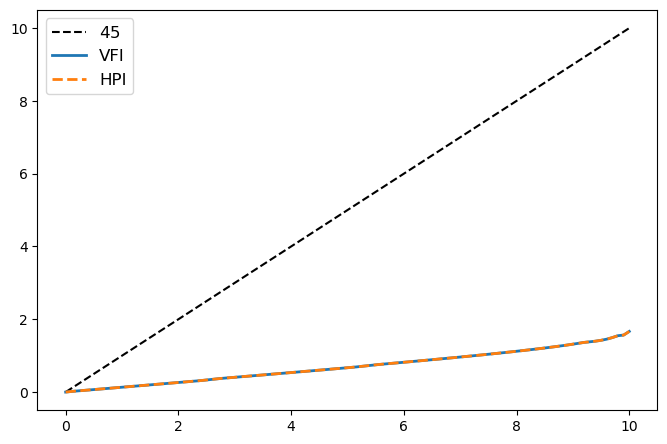

In [40]:
fig, ax = plt.subplots(figsize=(8, 5.2))
ax.plot(w_grid, w_grid, "k--", label=L"45")
ax.plot(w_grid, σ_star, lw=2, label="VFI")
ax.plot(w_grid, σ_star_hpi, "--", lw=2, label="HPI")
ax.legend(fontsize=fontsize)
plt.show()